C:\Users\swami\AppData\Local\Temp\ipykernel_15976\1035725201.py:14: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])
C:\Users\swami\Documents\MT\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 0.3378 - val_loss: nan
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0450 - val_loss: nan
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0232 - val_loss: nan
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0180 - val_loss: nan
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0139 - val_loss: nan
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0139 - val_loss: nan
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0075 - val_loss: nan
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0076 - val_loss: nan
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0066 - val_loss: nan
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0062 - val_loss: nan
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


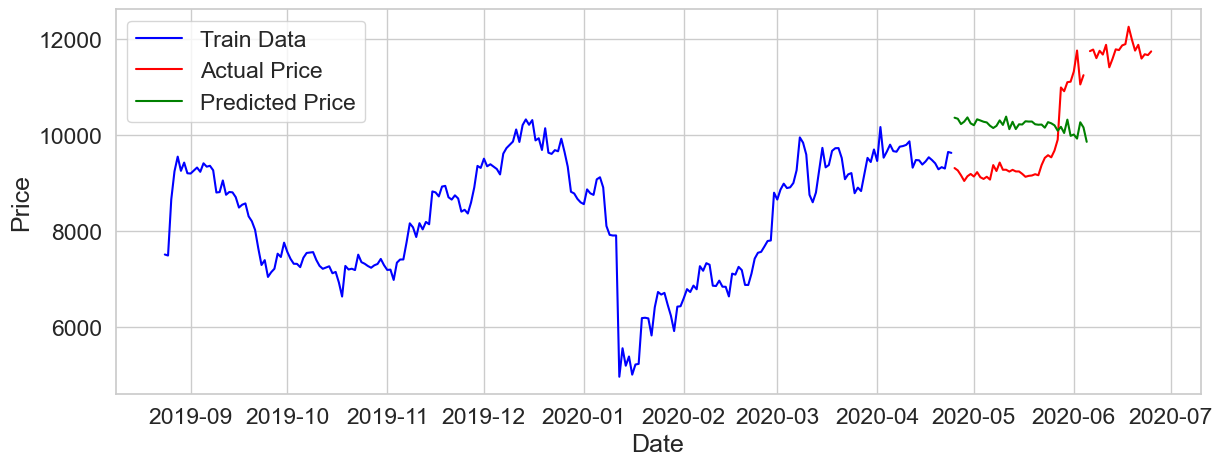

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
# Use your dataset here, for example a CSV file with BTC-USD data
data = pd.read_csv('BTC-USD.csv')  # Ensure columns have Date, Open, High, Low, Close, Volume, etc.

# Preprocess data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use Close price for prediction
prices = data[['Close']].values

# Scale data to range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

# Define training data
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create datasets
time_step = 60  # Using 60 days of historical data to predict the next day
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))  # Output layer for price prediction

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data.index[:len(train_predict)], y_train, color="blue", label="Train Data")
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], y_test, color="red", label="Actual Price")
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, color="green", label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
